# FHIR for Research Workshop

## Exercise 2

Intro: see https://github.com/NIH-NCPI/fhir-101/blob/master/FHIR%20101%20-%20Practical%20Guide.ipynb as a great example

## What is this notebook?

(common overview of the FHIR Training)

(overview of this specific notebook)




### Icons in this Guide
 📘 A link to a useful external reference related to the section the icon appears in  

 ⚡️ A key takeaway for the section that this icon appears in  

 🖐 A hands-on section where you will code something or interact with the server  


(any required MITRE legalese should either go here or at the very bottom of the notebook)

## Motivation / Purpose

Workshop attendees will learn how to query FHIR resources and use APIs to visualize and analyze data.  

What will participants do as part of the exercise?​

 - Identify patients with desired diagnosis and data elements across multiple studies/datasets​

 - Utilize APIs to explore the data (demographics)​

 - Utilize APIs for research analyses (phenotype analysis)

## Scenario

In this exercise we're going to explore how to access the data needed to generate the summary information from the Kids First dashboard in a few different ways. A snapshot of the Kids First dashboard is shown below:

![KF Dashboard](img/kf_dashboard.png)

The Kids First Data Portal is accessible at https://portal.kidsfirstdrc.org/explore (login required, though signup is free with any Google account)

For this exercise we'll be focusing on the following 4 graphs:
 - Demographics
 - Most frequent diagnoses
 - Age at diagnosis
 - Overall survival

## Environment Setup

In [1]:
# import any required libraries here.
import requests
#  - fhirclient: https://github.com/smart-on-fhir/client-py
from fhirclient import client
import pandas as pd 
#  - Pandas - DataFrames
#  - NumPy - basic data analysis
#  - matplotlib
#  - maybe seaborn for viz on top of matplotlib ?
import seaborn as sns

from datetime import datetime

In [2]:
# BASE_URL = 'https://api.logicahealth.org/researchonfhir/open'
BASE_URL = 'https://kf-api-fhir-service.kidsfirstdrc.org'

# We make a requests.Session to ensure consistent headers/cookies across all the requests we make
# TODO: don't put the actual cookie here, read from a separate file
s = requests.Session()
s.headers.update({'Accept': 'application/fhir+json'})
s.cookies['AWSELBAuthSessionCookie-0'] = "+gAzWgPwWmwpSy0b2871OuQoAcG2rW+63eHCPDZvvYeBtg5AmbIL6HaQfvsrEyPfXIizzU67j9vE6x0JSmME6dgjgPJP3Qj3sngS3vkN42I+w1TeNxVYpIrJNRt0L6olbb+EPeymLgqEHCyMjXfeQnjh4qj8bffKMCMBjQCjIHkBvRdthk0S8MnNRncpcGAmAo4VLTGN53duY3Ndl0jW8eJYoO55YUdb28C2kMPt1mAKqcgH+SsjNwXa7BA5D2G0YYUubLysoKcOaNeGX4DnviRzgr73k9m5zuEOLqzEkO2/pb7sZQcugrdtGUR14FE7S48ig/lmIOsqZ0vj/3UdBsKGzS0eWWHbSqWCdHlFeoGqJjOTs9XEL0c9XJVL2lPB8fs/d79APWPGaYi35aWRNtcXgC/y53cdTuvpZpd9S8xO4S0BJSjYAWtzfrHadFQtkT+MqSKkfrJt3e7rgbqrmm/+bjRXEGf+mg3cL/FOdJwiQRyOYzFac+QfqukG9CDoFmuafZpDKrsw3jE7GnwrTWh6GDpadzVFpVS9VH7EqL89XAND0FyJnD9C50OAz30em8qhgRAftkgg+xWFNJCc1PGf9iYRwzVExuIthfJk0+VSoBxnut0mF9H36v6ggVb1Ld3n96r9WPgUNr/YNLjNqRHXc4WswIF2pF4AXTxpwyAcdtYdA3IvFFLoJ2bkp+bZG2S2UbYh4Rd4fDTkMyGw5rOX6z25MlFrAXduYLpBTOK67pMn9Vi6a8s26QH+rMVZd8uBL8qfO57G7Qr1D54NcCwgRDyKBA8uo/ibUFqkQylC4EtAt9FhZJ4oa3YLrYU0LbTwhjCk84NP0DW0/ZcO5fbb0hON0AEIALq+ZXrxK/OLpXs9qvLbxItsSqLhTP5vl+Gw4SzndvfjV5yKvAtgHCmRptCeSxuBQ4QLJsbLQg406gxws6lZhf6NuRPhIxcSOopfg/zpvZokmdCQ1ga4WKla2qgylY8Tx6NXKppAIM+gy0MVlheOzoEE4lBVR2HDMkpw8VBHMPA1luMsylAHGBzlwfChiDAPaFG+BMgaBVdBt8czvDRnwUIcodPIAqcIxZaLrXo3myUNRQUd/AXlBY7Y3PghOJSk+RSfY+yC+R3bPDt3xbrv11t46a6YMFOYSlQaAJc/dyadyibStz3dZGmRpAHOvO4EtHA2YkxETu91kes5HY3SBHZTWm0xIr/4U7+A6njsilYk+eKuS7sDIGxDn5AGo0i6/AcrKgdoB5PwTaPeCZaBFDEoJDYsfZFGG1c0cT52gBUymUAzfPb/Z5BAiF/Qv+zCyE0X/vvnSuWov0d9D/uF3S1jjp/3RhM/qHBpu1y4hSJEyJ/CutpGZdItCFC0FOpoNUnD5R++14xPQ27sqfM1/5C6p6W19NniJsenhRZ8TM17cQ2eqOiv9FeGhunrWlh6YrJWlhGsVzhjmeKIY0hqGtvDct/OVAUURhufzoYQM4wWGcdQYrEF"

# disable SSL verification, these 2 lines should be commented out unless you actually see certificate errors
s.verify = False
requests.packages.urllib3.disable_warnings()

## 1. Demographics

First, let's show how to review basic demographic information for a patient cohort. There are a few ways we can do this.

### 1.1. Just the first N patients on the server

For the simplest example, let's just query for the first set of Patients on the server and see what that looks like.

In [3]:
# server by default returns 50 results at a time, we can specify a count up to 250
# note that there are >10k patients on the server so we may not want to query them all at once 

r = s.get(f"{BASE_URL}/Patient")
bundle = r.json()
bundle

{'resourceType': 'Bundle',
 'id': 'ac9bc6d9-21b3-4eba-af7e-e35683a00ea9',
 'meta': {'lastUpdated': '2022-01-07T00:52:26.834+00:00'},
 'type': 'searchset',
 'link': [{'relation': 'self',
   'url': 'https://kf-api-fhir-service.kidsfirstdrc.org/Patient'},
  {'relation': 'next',
   'url': 'https://kf-api-fhir-service.kidsfirstdrc.org?_getpages=ac9bc6d9-21b3-4eba-af7e-e35683a00ea9&_getpagesoffset=50&_count=50&_pretty=true&_bundletype=searchset'}],
 'entry': [{'fullUrl': 'https://kf-api-fhir-service.kidsfirstdrc.org/Patient/103070',
   'resource': {'resourceType': 'Patient',
    'id': '103070',
    'meta': {'versionId': '2',
     'lastUpdated': '2021-11-16T09:49:02.048+00:00',
     'source': '#yOJAbnQcyXm5DGen',
     'profile': ['http://hl7.org/fhir/StructureDefinition/Patient'],
     'tag': [{'code': 'SD_0TYVY1TW'}]},
    'extension': [{'url': 'http://hl7.org/fhir/us/core/StructureDefinition/us-core-race',
      'extension': [{'url': 'text', 'valueString': 'Not Reported'}]},
     {'url': 'h

In [4]:
# Let's filter the bundle down to just a list of Patient resources, and see what one Patient resource contains

patients = list(map(lambda e: e['resource'], bundle['entry']))
patients[0]

{'resourceType': 'Patient',
 'id': '103070',
 'meta': {'versionId': '2',
  'lastUpdated': '2021-11-16T09:49:02.048+00:00',
  'source': '#yOJAbnQcyXm5DGen',
  'profile': ['http://hl7.org/fhir/StructureDefinition/Patient'],
  'tag': [{'code': 'SD_0TYVY1TW'}]},
 'extension': [{'url': 'http://hl7.org/fhir/us/core/StructureDefinition/us-core-race',
   'extension': [{'url': 'text', 'valueString': 'Not Reported'}]},
  {'url': 'http://hl7.org/fhir/us/core/StructureDefinition/us-core-ethnicity',
   'extension': [{'url': 'text', 'valueString': 'Not Reported'}]}],
 'identifier': [{'value': '2-4F'},
  {'system': 'https://kf-api-dataservice.kidsfirstdrc.org/participants/',
   'value': 'PT_803DN7MS'},
  {'system': 'urn:kids-first:unique-string',
   'value': 'Patient-SD_0TYVY1TW-PT_803DN7MS'}],
 'gender': 'male'}

In [5]:
# We can see the key data items we are looking for - gender, race, and ethnicity

# Let's convert the list of Patients to a DataFrame and translate columns as appropriate

In [6]:
patients_df = pd.DataFrame(patients)
patients_df.head()

,resourceType,id,meta,extension,identifier,gender,_birthDate
0,Patient,103070,"{'versionId': '2', 'lastUpdated': '2021-11-16T...",[{'url': 'http://hl7.org/fhir/us/core/Structur...,"[{'value': '2-4F'}, {'system': 'https://kf-api...",male,NaN
1,Patient,103310,"{'versionId': '2', 'lastUpdated': '2021-11-16T...",[{'url': 'http://hl7.org/fhir/us/core/Structur...,"[{'value': '46008'}, {'system': 'https://kf-ap...",male,NaN
2,Patient,103462,"{'versionId': '2', 'lastUpdated': '2021-11-16T...",[{'url': 'http://hl7.org/fhir/us/core/Structur...,"[{'value': '45251'}, {'system': 'https://kf-ap...",female,NaN
3,Patient,103443,"{'versionId': '2', 'lastUpdated': '2021-11-16T...",[{'url': 'http://hl7.org/fhir/us/core/Structur...,"[{'value': '4-15M'}, {'system': 'https://kf-ap...",female,NaN
4,Patient,103494,"{'versionId': '2', 'lastUpdated': '2021-11-16T...",[{'url': 'http://hl7.org/fhir/us/core/Structur...,"[{'value': '445'}, {'system': 'https://kf-api-...",male,NaN


<AxesSubplot:ylabel='gender'>

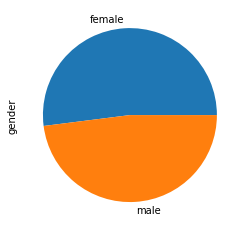

In [7]:
# Gender is easy to review - it's a column all by itself. Let's take a look at the gender breakdown.

patients_df['gender'].value_counts().plot.pie()

In [8]:
# Race and Ethnicity are trickier - as we see in the Patient JSON those are extensions, which we will have to parse out.
# Let's define functions to find the Race and Ethnicity on a Patient resource:

def get_us_core_extension_value(key, extensions):
    url = f"http://hl7.org/fhir/us/core/StructureDefinition/us-core-{key}"
    extension = next(filter(lambda e: e['url'] == url, extensions), None)
    if extension is None:
        return None
    
    extension = extension['extension'][0]
    
    if 'valueString' in extension:
        return extension['valueString']
    elif 'valueCoding' in extension:
        return extension['valueCoding']['display']
    
    return None

#
def get_race(extensions):
    return get_us_core_extension_value('race', extensions)
    
def get_ethnicity(extensions):
    return get_us_core_extension_value('ethnicity', extensions)

In [9]:
# And then use those functions to get Race and Ethnicity as columns in our DataFrame

patients_df['race'] = patients_df['extension'].map(lambda e: get_race(e))
patients_df['ethnicity'] = patients_df['extension'].map(lambda e: get_ethnicity(e))

patients_df.head()

,resourceType,id,meta,extension,identifier,gender,_birthDate,race,ethnicity
0,Patient,103070,"{'versionId': '2', 'lastUpdated': '2021-11-16T...",[{'url': 'http://hl7.org/fhir/us/core/Structur...,"[{'value': '2-4F'}, {'system': 'https://kf-api...",male,NaN,Not Reported,Not Reported
1,Patient,103310,"{'versionId': '2', 'lastUpdated': '2021-11-16T...",[{'url': 'http://hl7.org/fhir/us/core/Structur...,"[{'value': '46008'}, {'system': 'https://kf-ap...",male,NaN,White,Not Hispanic or Latino
2,Patient,103462,"{'versionId': '2', 'lastUpdated': '2021-11-16T...",[{'url': 'http://hl7.org/fhir/us/core/Structur...,"[{'value': '45251'}, {'system': 'https://kf-ap...",female,NaN,White,Not Hispanic or Latino
3,Patient,103443,"{'versionId': '2', 'lastUpdated': '2021-11-16T...",[{'url': 'http://hl7.org/fhir/us/core/Structur...,"[{'value': '4-15M'}, {'system': 'https://kf-ap...",female,NaN,White,Not Hispanic or Latino
4,Patient,103494,"{'versionId': '2', 'lastUpdated': '2021-11-16T...",[{'url': 'http://hl7.org/fhir/us/core/Structur...,"[{'value': '445'}, {'system': 'https://kf-api-...",male,NaN,White,Not Hispanic or Latino


<AxesSubplot:ylabel='race'>

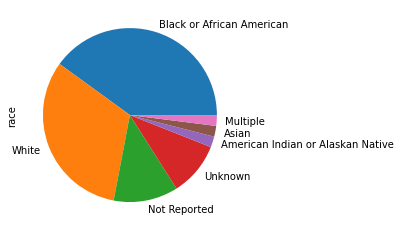

In [10]:
# Now let's review the summary of these:
# TODO: there is probably a way to group these into one cell but I don't know what it is
patients_df['race'].value_counts().plot.pie()

<AxesSubplot:ylabel='ethnicity'>

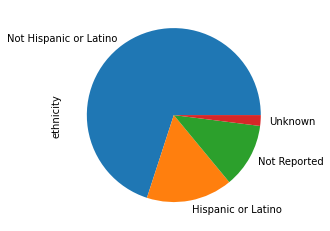

In [11]:
patients_df['ethnicity'].value_counts().plot.pie()

### 1.2. Patients with a given Condition

In the previous steps we reviewed what is essentially a random set of Patients, just the first set that the server returned when we asked for all Patients. Now let's get more targeted and query for just patients who have a diagnosis of a particular Condition. Then we can use the same functions we've already defined to analyze it.


TODO: Kids First uses MONDO codes, add some explanation of the codes.

In [12]:
r = s.get(f"{BASE_URL}/Patient?_has:Condition:patient:code=MONDO:0021640")
bundle = r.json()
patients = list(map(lambda e: e['resource'], bundle['entry']))
patients_df = pd.DataFrame(patients)

patients_df['race'] = patients_df['extension'].map(lambda e: get_race(e))
patients_df['ethnicity'] = patients_df['extension'].map(lambda e: get_ethnicity(e))

patients_df.head()

,resourceType,id,meta,extension,identifier,gender,race,ethnicity
0,Patient,76734,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'url': 'http://hl7.org/fhir/us/core/Structur...,[{'system': 'https://kf-api-dataservice.kidsfi...,female,White,Not Hispanic or Latino
1,Patient,76753,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'url': 'http://hl7.org/fhir/us/core/Structur...,[{'system': 'https://kf-api-dataservice.kidsfi...,male,White,Not Hispanic or Latino
2,Patient,76748,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'url': 'http://hl7.org/fhir/us/core/Structur...,[{'system': 'https://kf-api-dataservice.kidsfi...,male,White,Not Hispanic or Latino
3,Patient,76756,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'url': 'http://hl7.org/fhir/us/core/Structur...,[{'system': 'https://kf-api-dataservice.kidsfi...,female,Other,Not Reported
4,Patient,76750,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'url': 'http://hl7.org/fhir/us/core/Structur...,[{'system': 'https://kf-api-dataservice.kidsfi...,unknown,Not Available,Not Available


<AxesSubplot:ylabel='gender'>

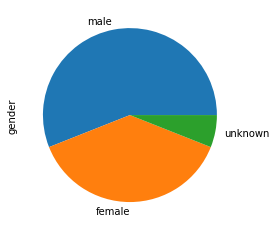

In [13]:
# And let's review the graphs:
patients_df['gender'].value_counts().plot.pie()

<AxesSubplot:ylabel='race'>

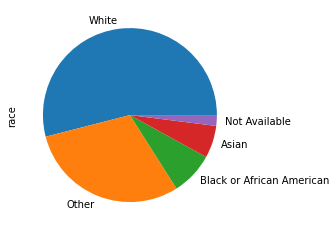

In [14]:
patients_df['race'].value_counts().plot.pie()

<AxesSubplot:ylabel='ethnicity'>

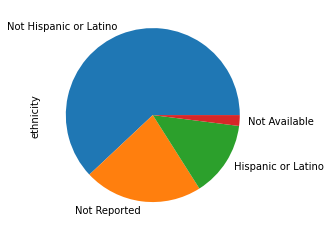

In [15]:
patients_df['ethnicity'].value_counts().plot.pie()

### 1.3. Patients within a given Research Study

Kids First comprises of multiple research studies: (TODO: image here, and pick a good study that has a reasonable number)
https://portal.kidsfirstdrc.org/studies

In this example we'll explore how to query for patients specifically associated to one of these research studies.

In [16]:
# First let's find the study we are interested in as a ResearchStudy:

r = s.get(f"{BASE_URL}/ResearchStudy")
bundle = r.json()
bundle

{'resourceType': 'Bundle',
 'id': 'c9f59f74-a1e3-4c1e-8f4a-58a35bdc2756',
 'meta': {'lastUpdated': '2022-01-07T00:52:28.099+00:00'},
 'type': 'searchset',
 'total': 29,
 'link': [{'relation': 'self',
   'url': 'https://kf-api-fhir-service.kidsfirstdrc.org/ResearchStudy'}],
 'entry': [{'fullUrl': 'https://kf-api-fhir-service.kidsfirstdrc.org/ResearchStudy/281300',
   'resource': {'resourceType': 'ResearchStudy',
    'id': '281300',
    'meta': {'versionId': '1',
     'lastUpdated': '2021-10-15T11:19:45.641+00:00',
     'source': '#YWSMBscCf7B7QqSD',
     'profile': ['http://hl7.org/fhir/StructureDefinition/ResearchStudy']},
    'identifier': [{'system': 'https://kf-api-dataservice.kidsfirstdrc.org/studies/',
      'value': 'SD_1P41Z782'},
     {'system': 'urn:kids-first:unique-string',
      'value': 'ResearchStudy-SD_1P41Z782'}],
    'title': 'OpenDIPG: ICR London',
    'status': 'completed',
    'condition': [{'coding': [{'system': 'http://snomed.info/sct',
        'code': '86049000',

In [17]:
# Looks like we want ID XXXXXXX
# Now we can query for ResearchSubjects by this ResearchStudy
# /ResearchSubject?study=22088

In [18]:
# And more importantly we can query for Patient resources by ResearchStudy via the ResearchSubjects,
# and again run our same functions

r = s.get(f"{BASE_URL}/Patient?_has:ResearchSubject:individual:study=76758")
bundle = r.json()
patients = list(map(lambda e: e['resource'], bundle['entry']))
patients_df = pd.DataFrame(patients)

patients_df['race'] = patients_df['extension'].map(lambda e: get_race(e))
patients_df['ethnicity'] = patients_df['extension'].map(lambda e: get_ethnicity(e))

patients_df.head()

,resourceType,id,meta,extension,identifier,gender,race,ethnicity
0,Patient,76747,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'url': 'http://hl7.org/fhir/us/core/Structur...,[{'system': 'https://kf-api-dataservice.kidsfi...,female,Other,Hispanic or Latino
1,Patient,76722,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'url': 'http://hl7.org/fhir/us/core/Structur...,[{'system': 'https://kf-api-dataservice.kidsfi...,male,White,Not Hispanic or Latino
2,Patient,76718,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'url': 'http://hl7.org/fhir/us/core/Structur...,[{'system': 'https://kf-api-dataservice.kidsfi...,female,White,Not Hispanic or Latino
3,Patient,76744,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'url': 'http://hl7.org/fhir/us/core/Structur...,[{'system': 'https://kf-api-dataservice.kidsfi...,female,White,Not Hispanic or Latino
4,Patient,76732,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'url': 'http://hl7.org/fhir/us/core/Structur...,[{'system': 'https://kf-api-dataservice.kidsfi...,female,White,Not Hispanic or Latino


<AxesSubplot:ylabel='gender'>

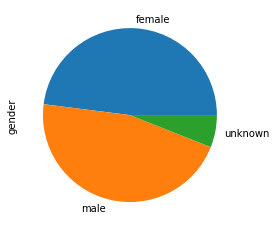

In [19]:
patients_df['gender'].value_counts().plot.pie()

<AxesSubplot:ylabel='race'>

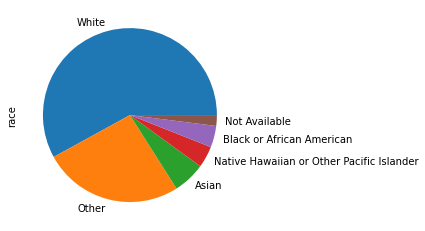

In [20]:
patients_df['race'].value_counts().plot.pie()

<AxesSubplot:ylabel='ethnicity'>

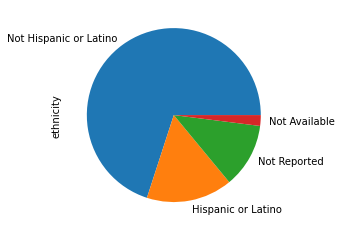

In [21]:
patients_df['ethnicity'].value_counts().plot.pie()

## 2. Most Frequent Diagnoses



### 2.1. Just the first conditions on the server

As before, ....

In [22]:
# let's look for 250 Condition resources
r = s.get(f"{BASE_URL}/Condition?_count=250")
bundle = r.json()
bundle

{'resourceType': 'Bundle',
 'id': '7ef6b8b1-8ca7-4b99-9ccb-c6ee6c709774',
 'meta': {'lastUpdated': '2022-01-07T00:52:28.850+00:00'},
 'type': 'searchset',
 'link': [{'relation': 'self',
   'url': 'https://kf-api-fhir-service.kidsfirstdrc.org/Condition?_count=250'},
  {'relation': 'next',
   'url': 'https://kf-api-fhir-service.kidsfirstdrc.org?_getpages=7ef6b8b1-8ca7-4b99-9ccb-c6ee6c709774&_getpagesoffset=250&_count=250&_pretty=true&_bundletype=searchset'}],
 'entry': [{'fullUrl': 'https://kf-api-fhir-service.kidsfirstdrc.org/Condition/4935',
   'resource': {'resourceType': 'Condition',
    'id': '4935',
    'meta': {'versionId': '1',
     'lastUpdated': '2021-10-14T16:01:08.153+00:00',
     'source': '#cDMAiYdumLMIL2zr',
     'profile': ['http://hl7.org/fhir/StructureDefinition/Condition']},
    'identifier': [{'value': '01456-1-Renal systems dysfunction'}],
    'clinicalStatus': {'coding': [{'system': 'http://terminology.hl7.org/CodeSystem/condition-clinical',
       'code': 'inactive

In [23]:
# Let's filter the bundle down to just a list of Condition resources, and see what one Condition resource contains

conditions = list(map(lambda e: e['resource'], bundle['entry']))
conditions[0]

{'resourceType': 'Condition',
 'id': '4935',
 'meta': {'versionId': '1',
  'lastUpdated': '2021-10-14T16:01:08.153+00:00',
  'source': '#cDMAiYdumLMIL2zr',
  'profile': ['http://hl7.org/fhir/StructureDefinition/Condition']},
 'identifier': [{'value': '01456-1-Renal systems dysfunction'}],
 'clinicalStatus': {'coding': [{'system': 'http://terminology.hl7.org/CodeSystem/condition-clinical',
    'code': 'inactive',
    'display': 'Inactive'}],
  'text': 'No'},
 'verificationStatus': {'coding': [{'system': 'http://terminology.hl7.org/CodeSystem/condition-ver-status',
    'code': 'refuted',
    'display': 'Refuted'}],
  'text': 'No'},
 'category': [{'coding': [{'system': 'http://terminology.hl7.org/CodeSystem/condition-category',
     'code': 'encounter-diagnosis',
     'display': 'Encounter Diagnosis'}],
   'text': 'Health Status'}],
 'code': {'coding': [{'system': 'http://purl.obolibrary.org/obo/hp.owl',
    'code': 'HP:0012211',
    'display': 'Abnormal renal physiology'}],
  'text': 'Re

In [24]:
# The key here is nested within the 'code' field, so let's get these into a DataFrame and translate it

conditions_df = pd.DataFrame(conditions)
conditions_df.head()

,resourceType,id,meta,identifier,clinicalStatus,verificationStatus,category,code,subject,_onsetDateTime
0,Condition,4935,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'value': '01456-1-Renal systems dysfunction'}],{'coding': [{'system': 'http://terminology.hl7...,{'coding': [{'system': 'http://terminology.hl7...,[{'coding': [{'system': 'http://terminology.hl...,{'coding': [{'system': 'http://purl.obolibrary...,{'reference': 'Patient/4804'},NaN
1,Condition,4943,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'value': '01456-1-Autoimmune disorders'}],{'coding': [{'system': 'http://terminology.hl7...,{'coding': [{'system': 'http://terminology.hl7...,[{'coding': [{'system': 'http://terminology.hl...,{'coding': [{'system': 'http://purl.obolibrary...,{'reference': 'Patient/4804'},NaN
2,Condition,4950,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'value': '01456-1-Acute kidney injury'}],NaN,NaN,[{'coding': [{'system': 'http://terminology.hl...,{'coding': [{'system': 'http://purl.obolibrary...,{'reference': 'Patient/4804'},NaN
3,Condition,4957,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'value': '01456-1-Cardiac failure'}],{'coding': [{'system': 'http://terminology.hl7...,{'coding': [{'system': 'http://terminology.hl7...,[{'coding': [{'system': 'http://terminology.hl...,{'coding': [{'system': 'http://purl.obolibrary...,{'reference': 'Patient/4804'},{'extension': [{'url': 'http://hl7.org/fhir/St...
4,Condition,4965,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'value': '01456-1-Hypertension'}],{'coding': [{'system': 'http://terminology.hl7...,{'coding': [{'system': 'http://terminology.hl7...,[{'coding': [{'system': 'http://terminology.hl...,{'coding': [{'system': 'http://purl.obolibrary...,{'reference': 'Patient/4804'},{'extension': [{'url': 'http://hl7.org/fhir/St...


In [25]:
# We'll define a function to pick a human-readable description out of the code field
## IMPORTANT: Look at the CodeableConcept page here, note what's optional and what's not. 
 # Things may break or look bad later if this isn't what we use
    
def get_code(c):
    if 'coding' in c:
        if display in c['coding'][0]:
            return c['coding'][0]['display']
        elif 'text' in c:
            return c['text']
        else:
            return c['coding'][0]['code']
    
    if 'text' in c:
        return c['text']

    return ''


conditions_df['description'] = conditions_df['code'].map(lambda c: get_code(c))

conditions_df.head()

,resourceType,id,meta,identifier,clinicalStatus,verificationStatus,category,code,subject,_onsetDateTime,description
0,Condition,4935,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'value': '01456-1-Renal systems dysfunction'}],{'coding': [{'system': 'http://terminology.hl7...,{'coding': [{'system': 'http://terminology.hl7...,[{'coding': [{'system': 'http://terminology.hl...,{'coding': [{'system': 'http://purl.obolibrary...,{'reference': 'Patient/4804'},NaN,Renal systems dysfunction
1,Condition,4943,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'value': '01456-1-Autoimmune disorders'}],{'coding': [{'system': 'http://terminology.hl7...,{'coding': [{'system': 'http://terminology.hl7...,[{'coding': [{'system': 'http://terminology.hl...,{'coding': [{'system': 'http://purl.obolibrary...,{'reference': 'Patient/4804'},NaN,Autoimmune disorders
2,Condition,4950,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'value': '01456-1-Acute kidney injury'}],NaN,NaN,[{'coding': [{'system': 'http://terminology.hl...,{'coding': [{'system': 'http://purl.obolibrary...,{'reference': 'Patient/4804'},NaN,Acute kidney injury
3,Condition,4957,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'value': '01456-1-Cardiac failure'}],{'coding': [{'system': 'http://terminology.hl7...,{'coding': [{'system': 'http://terminology.hl7...,[{'coding': [{'system': 'http://terminology.hl...,{'coding': [{'system': 'http://purl.obolibrary...,{'reference': 'Patient/4804'},{'extension': [{'url': 'http://hl7.org/fhir/St...,Cardiac failure
4,Condition,4965,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'value': '01456-1-Hypertension'}],{'coding': [{'system': 'http://terminology.hl7...,{'coding': [{'system': 'http://terminology.hl7...,[{'coding': [{'system': 'http://terminology.hl...,{'coding': [{'system': 'http://purl.obolibrary...,{'reference': 'Patient/4804'},{'extension': [{'url': 'http://hl7.org/fhir/St...,Hypertension


<AxesSubplot:xlabel='count', ylabel='description'>

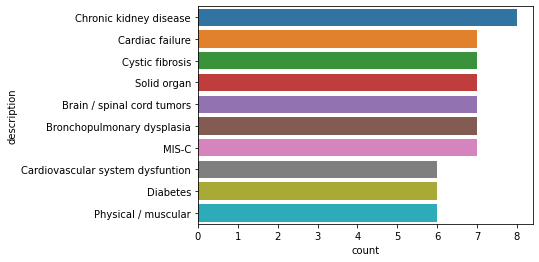

In [26]:
# Now let's graph the top 10 conditions
counts = conditions_df.groupby(['description']).count().reset_index()
counts.rename(columns={'resourceType': 'count'}, inplace=True)

counts = counts.sort_values('count', ascending=False).head(10)
sns.barplot(data=counts, x='count', y='description')

### 2.2. Patients in the Research Study

In [27]:
# In the previous steps, we looked at just a random sampling of Conditions: 
# the first 250 that the server happened to return. 
# Now let's return to the Research Study and see how we can query for just those Conditions.
# One might expect we can just chain even further, for example:
# /Condition?subject._has:ResearchSubject:individual:study=76758
# however that's not going to work here
# (it seems to hang the entire server for about 2 minutes so we encourage you not to actually run it)

r = s.get(f"{BASE_URL}/Patient?_has:ResearchSubject:individual:study=76758&_revinclude=Condition:subject")
bundle = r.json()
bundle

{'resourceType': 'Bundle',
 'id': '363616e3-3b28-4e15-9519-5de130cc4e5c',
 'meta': {'lastUpdated': '2022-01-07T00:52:30.154+00:00'},
 'type': 'searchset',
 'link': [{'relation': 'self',
   'url': 'https://kf-api-fhir-service.kidsfirstdrc.org/Patient?_has%3AResearchSubject%3Aindividual%3Astudy=76758&_revinclude=Condition%3Asubject'},
  {'relation': 'next',
   'url': 'https://kf-api-fhir-service.kidsfirstdrc.org?_getpages=363616e3-3b28-4e15-9519-5de130cc4e5c&_getpagesoffset=50&_count=50&_pretty=true&_include=Condition%3Asubject&_bundletype=searchset'}],
 'entry': [{'fullUrl': 'https://kf-api-fhir-service.kidsfirstdrc.org/Patient/76747',
   'resource': {'resourceType': 'Patient',
    'id': '76747',
    'meta': {'versionId': '1',
     'lastUpdated': '2021-10-14T20:38:13.215+00:00',
     'source': '#gPKhf1e42qBtShCI',
     'profile': ['http://hl7.org/fhir/StructureDefinition/Patient']},
    'extension': [{'url': 'http://hl7.org/fhir/us/core/StructureDefinition/us-core-race',
      'extensio

<AxesSubplot:xlabel='count', ylabel='description'>

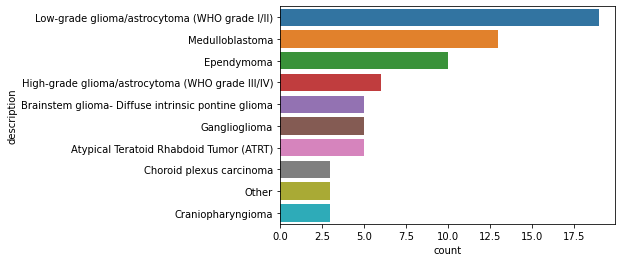

In [28]:
# So now we've done a _revinclude and we have 2 different resourceTypes in our results
# Let's filter to just the Conditions and re-use our functions from before:
all_resources = list(map(lambda e: e['resource'], bundle['entry']))
conditions = list(filter(lambda r: r['resourceType'] == 'Condition', all_resources))
conditions_df = pd.DataFrame(conditions)
conditions_df['description'] = conditions_df['code'].map(lambda c: get_code(c))
counts = conditions_df.groupby(['description']).count().reset_index()
counts.rename(columns={'resourceType': 'count'}, inplace=True)

counts = counts.sort_values('count', ascending=False).head(10)
sns.barplot(data=counts, x='count', y='description')

## 3. Age at Diagnosis

To calculate age at diagnosis, we need two pieces of information:
 - Date of Birth
 - Date of Diagnosis
 
In FHIR these may be captured in different resources that we may need to cross-reference:

- Patient.birthDate
- Condition.onset[x]
- Condition.recordedDate

Let's take a look at how the Kids First server represents these important concepts
# TODO: look at a sample Condition. though different Conditions have different contents and populated fields

### 3.1. Patients with a given Condition

In [47]:
r = s.get(f"{BASE_URL}/Condition?code=MONDO:0021640&_include=Condition:subject")
bundle = r.json()
bundle

{'resourceType': 'Bundle',
 'id': '84c272ba-d4e0-4de1-8460-5737e59233b3',
 'meta': {'lastUpdated': '2022-01-07T01:02:01.956+00:00'},
 'type': 'searchset',
 'link': [{'relation': 'self',
   'url': 'https://kf-api-fhir-service.kidsfirstdrc.org/Condition?_include=Condition%3Asubject&code=MONDO%3A0021640'},
  {'relation': 'next',
   'url': 'https://kf-api-fhir-service.kidsfirstdrc.org?_getpages=84c272ba-d4e0-4de1-8460-5737e59233b3&_getpagesoffset=50&_count=50&_pretty=true&_bundletype=searchset'}],
 'entry': [{'fullUrl': 'https://kf-api-fhir-service.kidsfirstdrc.org/Condition/81140',
   'resource': {'resourceType': 'Condition',
    'id': '81140',
    'meta': {'versionId': '1',
     'lastUpdated': '2021-10-14T20:55:27.459+00:00',
     'source': '#SNercAB8gxMDWvUz',
     'profile': ['https://nih-ncpi.github.io/ncpi-fhir-ig/StructureDefinition/disease']},
    'identifier': [{'system': 'https://kf-api-dataservice.kidsfirstdrc.org/diagnoses/',
      'value': 'DG_GF1W0YQY'},
     {'system': 'urn:

In [62]:
# Break the Bundle out into lists by resourceType
all_resources = list(map(lambda e: e['resource'], bundle['entry']))
conditions = list(filter(lambda r: r['resourceType'] == 'Condition', all_resources))
patients = list(filter(lambda r: r['resourceType'] == 'Patient', all_resources))

In [63]:
# turn them into DataFrames
conditions_df = pd.DataFrame(conditions)
patients_df = pd.DataFrame(patients)
patients_df.head()

,resourceType,id,meta,extension,identifier,gender
0,Patient,72513,"{'versionId': '2', 'lastUpdated': '2021-11-16T...",[{'url': 'http://hl7.org/fhir/us/core/Structur...,"[{'value': 'C25461'}, {'system': 'https://kf-a...",male
1,Patient,72448,"{'versionId': '2', 'lastUpdated': '2021-11-16T...",[{'url': 'http://hl7.org/fhir/us/core/Structur...,"[{'value': 'C1276494'}, {'system': 'https://kf...",female
2,Patient,72486,"{'versionId': '2', 'lastUpdated': '2021-11-16T...",[{'url': 'http://hl7.org/fhir/us/core/Structur...,"[{'value': 'C2558400'}, {'system': 'https://kf...",male
3,Patient,72459,"{'versionId': '2', 'lastUpdated': '2021-11-16T...",[{'url': 'http://hl7.org/fhir/us/core/Structur...,"[{'value': 'C1150665'}, {'system': 'https://kf...",male
4,Patient,72461,"{'versionId': '2', 'lastUpdated': '2021-11-16T...",[{'url': 'http://hl7.org/fhir/us/core/Structur...,"[{'value': 'C3588525'}, {'system': 'https://kf...",female


In [64]:
# now we're going to need to join these on Patient ID. Map the Condition.reference into a Patient ID field

def reference_to_id(reference):
    reference = reference['reference']
    if '/' in reference:
        idx = reference.index('/')
        return reference[idx+1:]
    else:
        return reference
    
conditions_df['patientId'] = conditions_df['subject'].map(reference_to_id)
conditions_df.head()

,resourceType,id,meta,identifier,clinicalStatus,verificationStatus,category,code,bodySite,subject,_recordedDate,patientId
0,Condition,81140,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'system': 'https://kf-api-dataservice.kidsfi...,{'coding': [{'system': 'http://terminology.hl7...,{'coding': [{'system': 'http://terminology.hl7...,[{'coding': [{'system': 'http://terminology.hl...,{'coding': [{'system': 'http://purl.obolibrary...,[{'text': 'Brain Stem- Midbrain/Tectum;Cerebel...,{'reference': 'Patient/72411'},{'extension': [{'url': 'http://hl7.org/fhir/St...,72411
1,Condition,81159,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'system': 'https://kf-api-dataservice.kidsfi...,{'coding': [{'system': 'http://terminology.hl7...,{'coding': [{'system': 'http://terminology.hl7...,[{'coding': [{'system': 'http://terminology.hl...,{'coding': [{'system': 'http://purl.obolibrary...,[{'text': 'Frontal Lobe;Temporal Lobe'}],{'reference': 'Patient/72432'},{'extension': [{'url': 'http://hl7.org/fhir/St...,72432
2,Condition,81126,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'system': 'https://kf-api-dataservice.kidsfi...,{'coding': [{'system': 'http://terminology.hl7...,{'coding': [{'system': 'http://terminology.hl7...,[{'coding': [{'system': 'http://terminology.hl...,{'coding': [{'system': 'http://purl.obolibrary...,[{'text': 'Not Reported'}],{'reference': 'Patient/72411'},{'extension': [{'url': 'http://hl7.org/fhir/St...,72411
3,Condition,81118,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'system': 'https://kf-api-dataservice.kidsfi...,{'coding': [{'system': 'http://terminology.hl7...,{'coding': [{'system': 'http://terminology.hl7...,[{'coding': [{'system': 'http://terminology.hl...,{'coding': [{'system': 'http://purl.obolibrary...,[{'text': 'Frontal Lobe'}],{'reference': 'Patient/72406'},{'extension': [{'url': 'http://hl7.org/fhir/St...,72406
4,Condition,81164,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'system': 'https://kf-api-dataservice.kidsfi...,{'coding': [{'system': 'http://terminology.hl7...,{'coding': [{'system': 'http://terminology.hl7...,[{'coding': [{'system': 'http://terminology.hl...,{'coding': [{'system': 'http://purl.obolibrary...,[{'text': 'Brain Stem- Pons'}],{'reference': 'Patient/72428'},{'extension': [{'url': 'http://hl7.org/fhir/St...,72428


In [65]:
# Now actually join the two DataFrames:
pat_conds_df = conditions_df.join(patients_df.set_index('id'), on='patientId', lsuffix='_c', rsuffix='_p')

pat_conds_df.head()

,resourceType_c,id,meta_c,identifier_c,clinicalStatus,verificationStatus,category,code,bodySite,subject,_recordedDate,patientId,resourceType_p,meta_p,extension,identifier_p,gender
0,Condition,81140,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'system': 'https://kf-api-dataservice.kidsfi...,{'coding': [{'system': 'http://terminology.hl7...,{'coding': [{'system': 'http://terminology.hl7...,[{'coding': [{'system': 'http://terminology.hl...,{'coding': [{'system': 'http://purl.obolibrary...,[{'text': 'Brain Stem- Midbrain/Tectum;Cerebel...,{'reference': 'Patient/72411'},{'extension': [{'url': 'http://hl7.org/fhir/St...,72411,Patient,"{'versionId': '2', 'lastUpdated': '2021-11-16T...",[{'url': 'http://hl7.org/fhir/us/core/Structur...,"[{'value': 'C3498612'}, {'system': 'https://kf...",male
1,Condition,81159,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'system': 'https://kf-api-dataservice.kidsfi...,{'coding': [{'system': 'http://terminology.hl7...,{'coding': [{'system': 'http://terminology.hl7...,[{'coding': [{'system': 'http://terminology.hl...,{'coding': [{'system': 'http://purl.obolibrary...,[{'text': 'Frontal Lobe;Temporal Lobe'}],{'reference': 'Patient/72432'},{'extension': [{'url': 'http://hl7.org/fhir/St...,72432,Patient,"{'versionId': '2', 'lastUpdated': '2021-11-16T...",[{'url': 'http://hl7.org/fhir/us/core/Structur...,"[{'value': 'C805035'}, {'system': 'https://kf-...",female
2,Condition,81126,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'system': 'https://kf-api-dataservice.kidsfi...,{'coding': [{'system': 'http://terminology.hl7...,{'coding': [{'system': 'http://terminology.hl7...,[{'coding': [{'system': 'http://terminology.hl...,{'coding': [{'system': 'http://purl.obolibrary...,[{'text': 'Not Reported'}],{'reference': 'Patient/72411'},{'extension': [{'url': 'http://hl7.org/fhir/St...,72411,Patient,"{'versionId': '2', 'lastUpdated': '2021-11-16T...",[{'url': 'http://hl7.org/fhir/us/core/Structur...,"[{'value': 'C3498612'}, {'system': 'https://kf...",male
3,Condition,81118,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'system': 'https://kf-api-dataservice.kidsfi...,{'coding': [{'system': 'http://terminology.hl7...,{'coding': [{'system': 'http://terminology.hl7...,[{'coding': [{'system': 'http://terminology.hl...,{'coding': [{'system': 'http://purl.obolibrary...,[{'text': 'Frontal Lobe'}],{'reference': 'Patient/72406'},{'extension': [{'url': 'http://hl7.org/fhir/St...,72406,Patient,"{'versionId': '2', 'lastUpdated': '2021-11-16T...",[{'url': 'http://hl7.org/fhir/us/core/Structur...,"[{'value': 'C60393'}, {'system': 'https://kf-a...",female
4,Condition,81164,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'system': 'https://kf-api-dataservice.kidsfi...,{'coding': [{'system': 'http://terminology.hl7...,{'coding': [{'system': 'http://terminology.hl7...,[{'coding': [{'system': 'http://terminology.hl...,{'coding': [{'system': 'http://purl.obolibrary...,[{'text': 'Brain Stem- Pons'}],{'reference': 'Patient/72428'},{'extension': [{'url': 'http://hl7.org/fhir/St...,72428,Patient,"{'versionId': '2', 'lastUpdated': '2021-11-16T...",[{'url': 'http://hl7.org/fhir/us/core/Structur...,"[{'value': 'C190896'}, {'system': 'https://kf-...",female


In [67]:
def parse_datetime(d):
    if len(d) == 4:
        return datetime.fromisoformat(d+"-01-01T00:00:00-04:00")
    elif len(d) == 10:
        return datetime.fromisoformat(d+"T00:00:00-04:00")
    else:
        return datetime.fromisoformat(d)
    
# print(pat_conds_df['onsetDateTime'].to_string())


pat_conds_df['birthDateAsDate'] = pat_conds_df['birthDate'].map(lambda d: parse_datetime(d))
pat_conds_df['onsetDateTimeAsDate'] = pat_conds_df['onsetDateTime'].map(lambda d: pd.Timestamp(parse_datetime(d)))


# pat_conds_df['birthDateAsDate'] = pd.to_datetime(pat_conds_df['birthDate'])
# pat_conds_df['onsetDateTimeAsDate'] = pd.to_datetime(pat_conds_df['onsetDateTime'])

# print(pat_conds_df['onsetDateTimeAsDate'].map(lambda x: type(x)).to_string())

# pat_conds_df['onsetDateTimeAsDate'].astype('datetime64[ns]')



pat_conds_df['onsetAge'] = pd.to_datetime(pat_conds_df['onsetDateTimeAsDate'], utc=True) - pd.to_datetime(pat_conds_df['birthDateAsDate'], utc=True)


pat_conds_df.head()

KeyError: 'birthDate'

### 3.2. Patients in the Research Study

In [68]:
r = s.get(f"{BASE_URL}/Patient?_has:ResearchSubject:individual:study=76758&_revinclude=Condition:subject")
bundle = r.json()
bundle

{'resourceType': 'Bundle',
 'id': '04481754-c75d-4bad-a015-55fb2762f1ce',
 'meta': {'lastUpdated': '2022-01-07T01:17:45.080+00:00'},
 'type': 'searchset',
 'link': [{'relation': 'self',
   'url': 'https://kf-api-fhir-service.kidsfirstdrc.org/Patient?_has%3AResearchSubject%3Aindividual%3Astudy=76758&_revinclude=Condition%3Asubject'},
  {'relation': 'next',
   'url': 'https://kf-api-fhir-service.kidsfirstdrc.org?_getpages=04481754-c75d-4bad-a015-55fb2762f1ce&_getpagesoffset=50&_count=50&_pretty=true&_include=Condition%3Asubject&_bundletype=searchset'}],
 'entry': [{'fullUrl': 'https://kf-api-fhir-service.kidsfirstdrc.org/Patient/76747',
   'resource': {'resourceType': 'Patient',
    'id': '76747',
    'meta': {'versionId': '1',
     'lastUpdated': '2021-10-14T20:38:13.215+00:00',
     'source': '#gPKhf1e42qBtShCI',
     'profile': ['http://hl7.org/fhir/StructureDefinition/Patient']},
    'extension': [{'url': 'http://hl7.org/fhir/us/core/StructureDefinition/us-core-race',
      'extensio

## 4. Overall Survival

### 4.1. Patients in the Research Study

In [69]:
r = s.get(f"{BASE_URL}/Patient?_has:ResearchSubject:individual:study=76758&_revinclude=Condition:subject&_revinclude=Observation:subject")
bundle = r.json()
bundle

{'resourceType': 'Bundle',
 'id': 'bc7f6f17-a052-40e4-958b-af481d477988',
 'meta': {'lastUpdated': '2022-01-07T01:18:23.926+00:00'},
 'type': 'searchset',
 'link': [{'relation': 'self',
   'url': 'https://kf-api-fhir-service.kidsfirstdrc.org/Patient?_has%3AResearchSubject%3Aindividual%3Astudy=76758&_revinclude=Condition%3Asubject&_revinclude=Observation%3Asubject'},
  {'relation': 'next',
   'url': 'https://kf-api-fhir-service.kidsfirstdrc.org?_getpages=bc7f6f17-a052-40e4-958b-af481d477988&_getpagesoffset=50&_count=50&_pretty=true&_include=Observation%3Asubject&_include=Condition%3Asubject&_bundletype=searchset'}],
 'entry': [{'fullUrl': 'https://kf-api-fhir-service.kidsfirstdrc.org/Patient/76747',
   'resource': {'resourceType': 'Patient',
    'id': '76747',
    'meta': {'versionId': '1',
     'lastUpdated': '2021-10-14T20:38:13.215+00:00',
     'source': '#gPKhf1e42qBtShCI',
     'profile': ['http://hl7.org/fhir/StructureDefinition/Patient']},
    'extension': [{'url': 'http://hl7.or

In [ ]:
# Break the Bundle out into lists by resourceType
all_resources = list(map(lambda e: e['resource'], bundle['entry']))
conditions = list(filter(lambda r: r['resourceType'] == 'Condition', all_resources))
patients = list(filter(lambda r: r['resourceType'] == 'Patient', all_resources))
observations = list(filter(lambda r: r['resourceType'] == 'Observation', all_resources))

In [34]:
result_entries = bundle['entry']

def next_bundle(bundle):
    if 'link' in bundle and isinstance(bundle['link'], list):
        return next((l for l in bundle['link'] if 'relation' in l and l['relation'] == 'next'), None)
    
    return None
                    
nextbundlelink = next_bundle(bundle)
                    
while nextbundlelink is not None and len(result_entries) < 1000:
    nextbundleurl = nextbundlelink['url']
    r = s.get(nextbundleurl)

    nextbundle = r.json()

    result_entries.extend(nextbundle['entry'])
                    
    nextbundlelink = next_bundle(nextbundle)


f"Found {len(result_entries)} total Condition entries"

'Found 1000 total Condition entries'

In [35]:
conditions = list(map(lambda e: e['resource'], result_entries))

def get_code(c):
    if 'code' in c:
        if 'coding' in c['code']:
            return c['code']['coding'][0]
    
    if 'text' in c:
        return {'display': c['text']}

    return {}

codes = list(map(lambda c: get_code(c), conditions))

codes_df = pd.DataFrame(codes, columns=['system', 'code', 'display'])

codes_df

,system,code,display
0,http://purl.obolibrary.org/obo/hp.owl,HP:0012211,Abnormal renal physiology
1,http://purl.obolibrary.org/obo/mondo.owl,MONDO:0007179,autoimmune disease
2,http://purl.obolibrary.org/obo/mondo.owl,MONDO:0002492,acute kidney failure
3,http://purl.obolibrary.org/obo/mondo.owl,MONDO:0005252,heart failure
4,http://purl.obolibrary.org/obo/hp.owl,HP:0000822,Hypertension
...,...,...,...
995,http://purl.obolibrary.org/obo/hp.owl,HP:0000126,NaN
996,http://purl.obolibrary.org/obo/hp.owl,HP:0001159,NaN
997,http://purl.obolibrary.org/obo/hp.owl,HP:0002251,NaN
998,http://purl.obolibrary.org/obo/hp.owl,HP:0000252,NaN


In [36]:
result_entries

[{'fullUrl': 'https://kf-api-fhir-service.kidsfirstdrc.org/Condition/4935',
  'resource': {'resourceType': 'Condition',
   'id': '4935',
   'meta': {'versionId': '1',
    'lastUpdated': '2021-10-14T16:01:08.153+00:00',
    'source': '#cDMAiYdumLMIL2zr',
    'profile': ['http://hl7.org/fhir/StructureDefinition/Condition']},
   'identifier': [{'value': '01456-1-Renal systems dysfunction'}],
   'clinicalStatus': {'coding': [{'system': 'http://terminology.hl7.org/CodeSystem/condition-clinical',
      'code': 'inactive',
      'display': 'Inactive'}],
    'text': 'No'},
   'verificationStatus': {'coding': [{'system': 'http://terminology.hl7.org/CodeSystem/condition-ver-status',
      'code': 'refuted',
      'display': 'Refuted'}],
    'text': 'No'},
   'category': [{'coding': [{'system': 'http://terminology.hl7.org/CodeSystem/condition-category',
       'code': 'encounter-diagnosis',
       'display': 'Encounter Diagnosis'}],
     'text': 'Health Status'}],
   'code': {'coding': [{'system'

<AxesSubplot:xlabel='count', ylabel='display'>

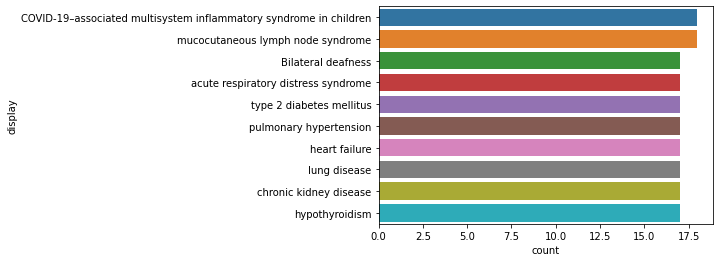

In [37]:
codes_df = codes_df.sort_values('code')

# i don't understand why but this groupby doesn't work on the KF data, maybe there are too many null fields 
# (KF doesn't seem to include display most of the time)
counts = codes_df.groupby(['code', 'display']).count().reset_index()

counts.rename(columns={'system': 'count'}, inplace=True)

counts = counts.sort_values('count', ascending=False).head(10)

codes_df
sns.barplot(data=counts, x='count', y='display')


## Step 2 Query Data for Selected Concepts

In [38]:
# Demographics

# gender -> Patient.gender
# race -> Patient.extension.us-core-race
# ethnicity -> Patient.extension.us-core-ethnicity

# note most of the logica default patients do not have race/ethnicity

# what the heck is family composition?


r = s.get(f"{BASE_URL}/Patient?_has:ResearchSubject:individual:study=76758&_count=250")

bundle = r.json()

result_entries = bundle['entry']

nextbundlelink = next_bundle(bundle)
                    
while nextbundlelink is not None:
    nextbundleurl = nextbundlelink['url']
    r = s.get(nextbundleurl)

    nextbundle = r.json()

    result_entries.extend(nextbundle['entry'])
                    
    nextbundlelink = next_bundle(nextbundle)


print(f"Found {len(result_entries)} total Patient entries")


patients = list(map(lambda e: e['resource'], result_entries))




Found 4358 total Patient entries


In [39]:
genders = list(map(lambda p: p['gender'] if 'gender' in p else None, patients))

def get_us_core_extension_value(key, extensions):
    url = f"http://hl7.org/fhir/us/core/StructureDefinition/us-core-{key}"
    
    extension = next(filter(lambda e: e['url'] == url, extensions), None)
    
    if extension is None:
        return None
    
    extension = extension['extension'][0]
    
    if 'valueString' in extension:
        return extension['valueString']
    elif 'valueCoding' in extension:
        return extension['valueCoding']['display']
    
    return None

#
def get_race(patient):
    if 'extension' not in patient:
        return None
    return get_us_core_extension_value('race', patient['extension'])
    
def get_ethnicity(patient):
    if 'extension' not in patient:
        return None
    return get_us_core_extension_value('ethnicity', patient['extension'])

races = list(map(lambda p: get_race(p), patients))
ethnicities = list(map(lambda p: get_ethnicity(p), patients))

genders

['female',
 'male',
 'female',
 'female',
 'female',
 'male',
 'female',
 'female',
 'female',
 'male',
 'male',
 'male',
 'male',
 'female',
 'male',
 'male',
 'unknown',
 'female',
 'male',
 'female',
 'female',
 'female',
 'male',
 'male',
 'female',
 'male',
 'male',
 'female',
 'female',
 'male',
 'male',
 'unknown',
 'female',
 'female',
 'female',
 'male',
 'male',
 'male',
 'female',
 'male',
 'male',
 'male',
 'male',
 'female',
 'unknown',
 'female',
 'female',
 'male',
 'female',
 'female',
 'male',
 'female',
 'female',
 'male',
 'female',
 'female',
 'male',
 'male',
 'male',
 'male',
 'female',
 'male',
 'male',
 'female',
 'male',
 'male',
 'female',
 'male',
 'male',
 'male',
 'female',
 'male',
 'female',
 'male',
 'male',
 'male',
 'male',
 'male',
 'male',
 'unknown',
 'female',
 'male',
 'male',
 'male',
 'male',
 'male',
 'male',
 'male',
 'male',
 'female',
 'male',
 'female',
 'female',
 'male',
 'female',
 'male',
 'female',
 'female',
 'female',
 'male',
 'unkn

<AxesSubplot:ylabel='None'>

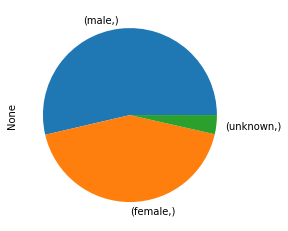

In [40]:
pd.DataFrame(genders).value_counts().plot.pie()

<AxesSubplot:ylabel='None'>

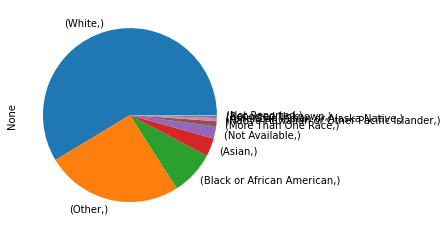

In [41]:
pd.DataFrame(races).value_counts().plot.pie()

<AxesSubplot:ylabel='None'>

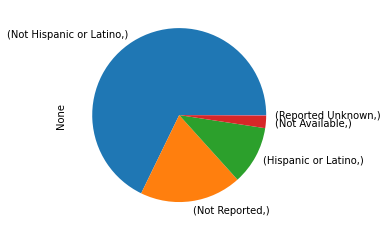

In [42]:
pd.DataFrame(ethnicities).value_counts().plot.pie()

In [43]:
# Age at Diagnosis

# condition recordedDate

# query condition & patient, join on patient ID

# note we already have conditions and patients loaded from before

conditions_df = pd.DataFrame(conditions)
patients_df = pd.DataFrame(patients)


In [44]:
def reference_to_id(reference):
    reference = reference['reference']
    if '/' in reference:
        idx = reference.index('/')
        return reference[idx+1:]
    else:
        return reference
    
conditions_df['patientId'] = conditions_df['subject'].map(reference_to_id)
conditions_df.head()



,resourceType,id,meta,identifier,clinicalStatus,verificationStatus,category,code,subject,_onsetDateTime,bodySite,patientId
0,Condition,4935,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'value': '01456-1-Renal systems dysfunction'}],{'coding': [{'system': 'http://terminology.hl7...,{'coding': [{'system': 'http://terminology.hl7...,[{'coding': [{'system': 'http://terminology.hl...,{'coding': [{'system': 'http://purl.obolibrary...,{'reference': 'Patient/4804'},NaN,NaN,4804
1,Condition,4943,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'value': '01456-1-Autoimmune disorders'}],{'coding': [{'system': 'http://terminology.hl7...,{'coding': [{'system': 'http://terminology.hl7...,[{'coding': [{'system': 'http://terminology.hl...,{'coding': [{'system': 'http://purl.obolibrary...,{'reference': 'Patient/4804'},NaN,NaN,4804
2,Condition,4950,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'value': '01456-1-Acute kidney injury'}],NaN,NaN,[{'coding': [{'system': 'http://terminology.hl...,{'coding': [{'system': 'http://purl.obolibrary...,{'reference': 'Patient/4804'},NaN,NaN,4804
3,Condition,4957,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'value': '01456-1-Cardiac failure'}],{'coding': [{'system': 'http://terminology.hl7...,{'coding': [{'system': 'http://terminology.hl7...,[{'coding': [{'system': 'http://terminology.hl...,{'coding': [{'system': 'http://purl.obolibrary...,{'reference': 'Patient/4804'},{'extension': [{'url': 'http://hl7.org/fhir/St...,NaN,4804
4,Condition,4965,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'value': '01456-1-Hypertension'}],{'coding': [{'system': 'http://terminology.hl7...,{'coding': [{'system': 'http://terminology.hl7...,[{'coding': [{'system': 'http://terminology.hl...,{'coding': [{'system': 'http://purl.obolibrary...,{'reference': 'Patient/4804'},{'extension': [{'url': 'http://hl7.org/fhir/St...,NaN,4804


In [45]:
pat_conds_df = conditions_df.join(patients_df.set_index('id'), on='patientId', lsuffix='_c', rsuffix='_p')

pat_conds_df.head()

,resourceType_c,id,meta_c,identifier_c,clinicalStatus,verificationStatus,category,code,subject,_onsetDateTime,bodySite,patientId,resourceType_p,meta_p,extension,identifier_p,gender
0,Condition,4935,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'value': '01456-1-Renal systems dysfunction'}],{'coding': [{'system': 'http://terminology.hl7...,{'coding': [{'system': 'http://terminology.hl7...,[{'coding': [{'system': 'http://terminology.hl...,{'coding': [{'system': 'http://purl.obolibrary...,{'reference': 'Patient/4804'},NaN,NaN,4804,NaN,NaN,NaN,NaN,NaN
1,Condition,4943,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'value': '01456-1-Autoimmune disorders'}],{'coding': [{'system': 'http://terminology.hl7...,{'coding': [{'system': 'http://terminology.hl7...,[{'coding': [{'system': 'http://terminology.hl...,{'coding': [{'system': 'http://purl.obolibrary...,{'reference': 'Patient/4804'},NaN,NaN,4804,NaN,NaN,NaN,NaN,NaN
2,Condition,4950,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'value': '01456-1-Acute kidney injury'}],NaN,NaN,[{'coding': [{'system': 'http://terminology.hl...,{'coding': [{'system': 'http://purl.obolibrary...,{'reference': 'Patient/4804'},NaN,NaN,4804,NaN,NaN,NaN,NaN,NaN
3,Condition,4957,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'value': '01456-1-Cardiac failure'}],{'coding': [{'system': 'http://terminology.hl7...,{'coding': [{'system': 'http://terminology.hl7...,[{'coding': [{'system': 'http://terminology.hl...,{'coding': [{'system': 'http://purl.obolibrary...,{'reference': 'Patient/4804'},{'extension': [{'url': 'http://hl7.org/fhir/St...,NaN,4804,NaN,NaN,NaN,NaN,NaN
4,Condition,4965,"{'versionId': '1', 'lastUpdated': '2021-10-14T...",[{'value': '01456-1-Hypertension'}],{'coding': [{'system': 'http://terminology.hl7...,{'coding': [{'system': 'http://terminology.hl7...,[{'coding': [{'system': 'http://terminology.hl...,{'coding': [{'system': 'http://purl.obolibrary...,{'reference': 'Patient/4804'},{'extension': [{'url': 'http://hl7.org/fhir/St...,NaN,4804,NaN,NaN,NaN,NaN,NaN


In [66]:
def parse_datetime(d):
    if len(d) == 4:
        return datetime.fromisoformat(d+"-01-01T00:00:00-04:00")
    elif len(d) == 10:
        return datetime.fromisoformat(d+"T00:00:00-04:00")
    else:
        return datetime.fromisoformat(d)
    
# print(pat_conds_df['onsetDateTime'].to_string())


pat_conds_df['birthDateAsDate'] = pat_conds_df['birthDate'].map(lambda d: parse_datetime(d))
pat_conds_df['onsetDateTimeAsDate'] = pat_conds_df['onsetDateTime'].map(lambda d: pd.Timestamp(parse_datetime(d)))


# pat_conds_df['birthDateAsDate'] = pd.to_datetime(pat_conds_df['birthDate'])
# pat_conds_df['onsetDateTimeAsDate'] = pd.to_datetime(pat_conds_df['onsetDateTime'])

# print(pat_conds_df['onsetDateTimeAsDate'].map(lambda x: type(x)).to_string())

# pat_conds_df['onsetDateTimeAsDate'].astype('datetime64[ns]')



pat_conds_df['onsetAge'] = pd.to_datetime(pat_conds_df['onsetDateTimeAsDate'], utc=True) - pd.to_datetime(pat_conds_df['birthDateAsDate'], utc=True)


pat_conds_df.head()

KeyError: 'birthDate'

In [ ]:
# Overall Survival

# query condition, patient, observation

# https://kf-api-fhir-service.kidsfirstdrc.org/Observation?code=263493007
# code = "clinical status", value = "Alive" or "Dead" (display)/"Deceased" (text)
# note these are relative to dob

# condition recordedDate is also relative to dob


## Summary

(A review of what was done in this notebook, possibly reinforcing how this kind of use case could be useful in the real world)